Get the data on fragments of glass
collected in forensic work from the book website.
Estimate the density of the first variable
(refractive index) using a histogram and
a kernel density estimator.
Use cross-validation to choose the amount of smoothing.
Experiment with different binwidths and bandwiths.
Comment on the similarities and differences.
Construct 95 percent confidence bands for your estimators.

The data may be found at https://www.stat.cmu.edu/~larry/all-of-statistics/=data/glass.dat

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
# Read the data into a pandas data frame
glass_df = pd.read_csv('../data/glass_clean.dat', sep='\t')

# Transform the single dataframe column into a numpy array
glass_data = glass_df['RI'].to_numpy()

# Kernel density estimation

We only implement kernel density estimation using the *Gaussian* kernel.
This is because the Gaussian kernel is closed under convolution:
the convolution of two Gaussian kernels remains a Gaussian kernel. This makes computing $K^*$ below much easier.
(Actually, it appears that the Gaussian kernel is the only kernel
with finite variance with this property since it is the only
[stable distribution](https://en.wikipedia.org/wiki/Stable_distribution) with finite variance.)

To compute the approximation of the leave-one-out cross-validation
estimate of the risk of the kernel density estimator in `KDE.cv_risk`
we use the approximation
$$
    \hat J (h)
    \approx
    \frac{1}{nh^2} \sum_{i,j=1}^n K^* \left( \frac{x - X_i}{h} \right)
    + \frac{2}{nh} K(0)
$$
where $K^* = K^{(2)} - 2 K$ for $K^{(2)} = K \ast K$ such that,
for the Gaussian kernel $K$, $K^{(2)}$ is the PDF of a $N(0,2)$ random variable.

In [3]:
class KDE():
    """
    A kernel density estimator (KDE).
    
    Attributes
    bandwidth       float: the bandwidth of the kernel density estimator
    data            1D array: the sample points
    kernel          function: the kernel function
    
    Methods
    confidence_band       Create a 1-alpha confidence band on a given set of x-values
    cv_risk               Evaluate the cross-validation risk
    evaluate              Evaluate the KDE at a given 1D array of x-values
    plot                  Plot the KDE on a given axis object
                          with respect to a given 1D array of x-values
    plot_confidence_band  Plot the KDE and its confidence band
    """
    
    def __init__(self, kernel, bandwidth, data):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.data = data
        
    def confidence_band(self, x_arr, alpha=0.05):
        """
        Create a (1 - alpha) band for the kernel density estimator,
        given a 1D array of x-values on which to evaluate
        the lower and upper bounds.
        
        Only implemented for the Gaussian kernel.
        
        See Section 20.3 of the notes, on Kernel Density Estimation,
        for the identities used below.
        """
        
        K_Gaussian = scipy.stats.norm.pdf
        if self.kernel != K_Gaussian:
            raise ValueError('The cross-validation risk evaluation is only implement for the Gaussian kernel.')
        
        omega = 3*self.bandwidth
        m = (self.data.max() - self.data.min())/omega
        q = scipy.stats.norm.ppf((1 + (1 - alpha)**(1/m))/2)
        
        # Y_i (x) = K( (x - Xi)/h ) / h
        x_mesh, data_mesh = np.meshgrid(x_arr, self.data)
        Y = self.kernel((x_mesh - data_mesh)/self.bandwidth)/self.bandwidth
        
        s = Y.std(ddof=1, axis=0)
        se = s/np.sqrt(self.data.shape[0])
        
        f_hat = self.evaluate(x_arr)
        
        lower_bound = np.maximum(f_hat - q*se, 0)
        upper_bound = f_hat + q*se
        
        return lower_bound, upper_bound
     
    def cv_risk(self):
        """
        Evaluate the approximation of
        the leave-one-out cross-validation estimate
        of the kernel density estimator risk.
        """
        
        K_Gaussian = scipy.stats.norm.pdf
        if self.kernel != K_Gaussian:
            raise ValueError('The cross-validation risk evaluation is only implement for the Gaussian kernel.')
        
        K_star = lambda x : scipy.stats.norm.pdf(x, scale=np.sqrt(2)) - 2 * scipy.stats.norm.pdf(x)
        n = self.data.shape[0]
        h = self.bandwidth
        
        return (
            np.sum(K_star(
                np.tile(self.data, (n, 1)) - np.tile(self.data.reshape(n, 1), (1, n)) / h
            ))/(n**2*h)
            + 2*K_Gaussian(0)/(n*h)
        )
        
    def evaluate(self, x_arr):
        """
        Evaluate the kernel density estimator
        at every point in the 1D array x_arr.
        """
        
        # Y_i (x) = K( (x - Xi)/h ) / h
        x_mesh, data_mesh = np.meshgrid(x_arr, self.data)
        Y = self.kernel((x_mesh - data_mesh)/self.bandwidth)/self.bandwidth
        
        return Y.mean(axis=0)
    
    def plot(self, x_arr, axis):
        """
        Plot the kernel density estimator
        on a given axis object with respect to
        a given 1D array of x-values.
        """
        
        axis.plot(x_arr, self.evaluate(x_arr), label=f"h = {self.bandwidth}")
        
    def plot_confidence_band(self, x_arr, axis, alpha=0.05):
        """
        Plot the kernel density estimator on a given axis object,
        along with its 1-alpha confidence_band,
        with respect to a given 1D array of x-values.
        """
        
        lower_bound, upper_bound = self.confidence_band(x_arr, alpha)
        axs.fill_between(x_arr, lower_bound, upper_bound, alpha=0.3)
        kde.plot(x_arr, axs)

def create_cv_risk_list(data, plot_flag=False, hstart=0.05, hstop=1, hstep=0.01):
    """
    Given a 1D array data, take h ranging
    from hstart to hstop and, for each,
    compute the cross-validation risk.
    
    This is only implemented for the Gaussian kernel.
    
    Return both h_list, cv_risk_list,
    to make subsequent plotting easier, 
    as well as the optimal h (which minimizes
    the cross-validation risk).
    
    Plot the result, if asked.
    """
    
    n = data.shape[0]
    h_list = np.arange(start=hstart, stop=hstop, step=hstep)
    
    K_Gaussian = scipy.stats.norm.pdf
    cv_risk_function = lambda h : KDE(K_Gaussian, h, data).cv_risk()
    cv_risk_list = np.vectorize(cv_risk_function)(h_list)
    h_optimal = h_list[cv_risk_list.argmin()]
    
    if plot_flag:
        fig, axs = plt.subplots(1)
        axs.plot(h_list, cv_risk_list)
        axs.set_title('Cross-validation risk as a function of the bandwidth h')
        #plt.legend(loc='best')
        plt.show()
        plt.close()
    
    return h_list, cv_risk_list, h_optimal

## Carrying out the kernel density estimation

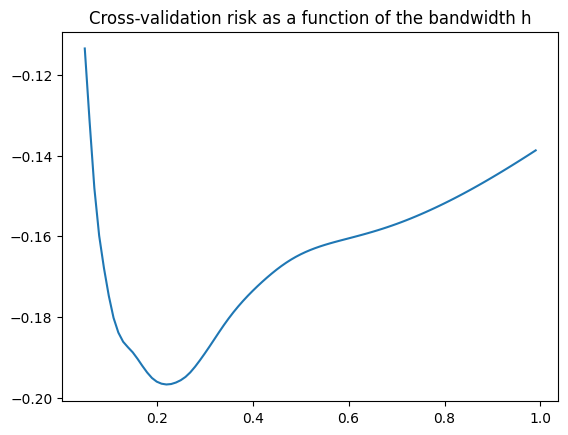

The optimal bandwidth (per cross-validation) is 0.22000000000000003.


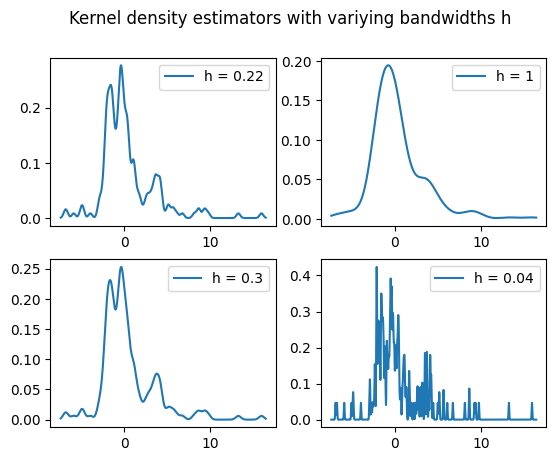

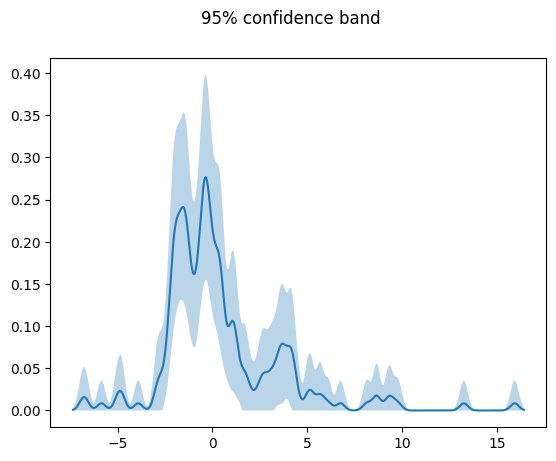

In [4]:
K_Gaussian = scipy.stats.norm.pdf

_, _, h_optimal = create_cv_risk_list(glass_data, plot_flag=True)
print(f"The optimal bandwidth (per cross-validation) is {h_optimal}.")

h_list = [0.22, 1, 0.3, 0.04]
x_arr = np.arange(start=glass_data.min()-0.5, stop=glass_data.max()+0.5, step=0.01)
fig, axs = plt.subplots(2, 2)
for axis, h in zip(axs.reshape(4), h_list):
    KDE(K_Gaussian, h, glass_data).plot(x_arr, axis)
    axis.legend(loc='best')
fig.suptitle('Kernel density estimators with variying bandwidths h')
plt.show()
plt.close()

kde = KDE(K_Gaussian, h_optimal, glass_data)
fig, axs = plt.subplots(1)
kde.plot_confidence_band(x_arr, axs)
fig.suptitle('95% confidence band')
plt.show()
plt.close()

## Kernel density estimation - Summary of results

1. Similarly to *histogram* estimation,
   the amount of smoothing in *kernel density* estimation
   may hide certain features of the PDF (when the amount of smoothing is too high)
   or suggest spurious features (when the amount of smoothing is too low).
1. A significant difference with histogram estimation
   is that, here, the approximation of the cross-validation
   risk estimate various smoothly as a function of
   the parameter (the bandwidth, in this case).
1. The confidence band is much tighter (and hence, useful),
   than in the case of histogram estimators.

# Applying to real data
We use a kernel density estimator to estimate
the run distance distributions in NFL games.

In [70]:
df = pd.read_csv("~/Documents/python/gridiron_data/data/nfl_savant/pbp-2023.csv")

# Keep only the rows where IsRush == 1
run_distance_data = df.loc[df['IsRush'].astype(bool)]['Yards'].to_numpy()

# Sanity check (expect 14,337 samples)
run_distance_data.shape

(14337,)

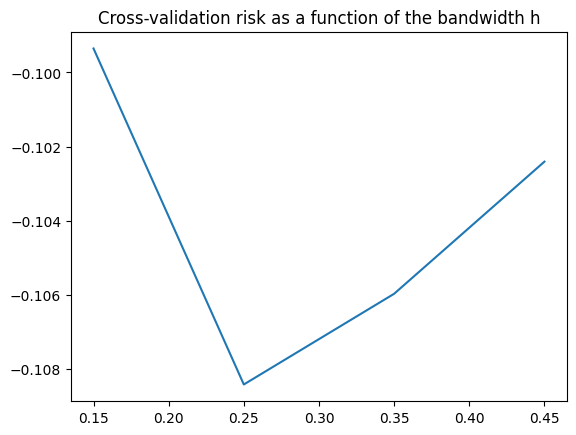

The optimal bandwidth (per cross-validation) is 0.25.


In [16]:
# Only compute the cross-validation risk for a small number of samples
# and a small number of bandwidths (too computationally expensive otherwise!)
n = int(4e3)

_, _, h_optimal = create_cv_risk_list(run_distance_data[:n], plot_flag=True, hstart=0.15, hstop=0.45, hstep=0.1)
print(f"The optimal bandwidth (per cross-validation) is {h_optimal}.")

# Take-away
Remember that the samples are integer-valued.
Since the optimal bandwidth seems to be around $h = 0.25$,
this means that even at the three-standard deviation size of $3h = 0.75$
the sample points do not *see* each other through the kernel with deviation $h$!

Therefore we might as well use simpler techniques which *assume* that the density is discrete
(as is the case here).

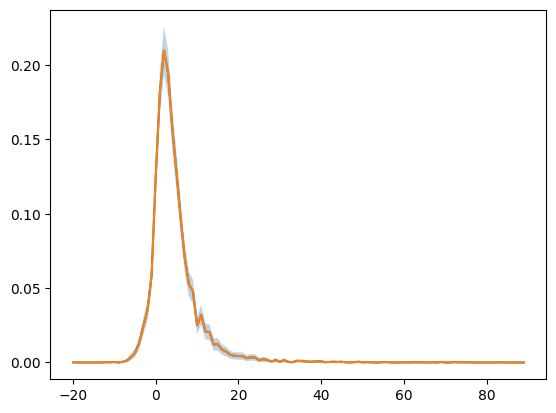

In [73]:
K_Gaussian = scipy.stats.norm.pdf
h = 0.25

kde = KDE(K_Gaussian, h, run_distance_data)

xmin = -20
xmax = 90

x_arr = np.arange(xmin, xmax, 1)
fig, axs = plt.subplots(1)
kde.plot(x_arr, axs)

kde.plot_confidence_band(x_arr, axs)